In [244]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import imp
import pymaster as nmt
import utils
import pysm
from pysm.nominal import models
from pysm.common import convert_units
from logLikeli import logLike
import time
%matplotlib inline

In [248]:
imp.reload(utils)
import logLikeli
imp.reload(logLikeli)

<module 'logLikeli' from '/home/jianyao/Likelihood/logLikeli.py'>

In [3]:
from Fg_template import sync_ps as sync_ps_v0
from Fg_template import dust_ps as dust_ps_v0
from Fg_template import corre_fore_simple

In [4]:
from multiprocessing import Pool, cpu_count

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc 

from iminuit import Minuit

In [113]:
from BP_beam_nmt_bin import BPE as BPE

In [133]:
import seaborn as sns

# Functions

In [94]:
nside = 1024; 
bin_w = 40;
lmin = 50;
lmax = 200;
beams = [19, 11]
SamNum = 50; 
Nf = 2; nf_ind = 3

lensingB = utils.Gencl(r = 0, raw_cl = True) ## only lensing BB; TT EE BB TE

bb_05 = utils.Gencl(r = 0.05, raw_cl = True, tensorBB_only=True) ##only tensor BB; ## 

In [95]:
def bands(nside, bin_w, lmin, lmax):
    ells = np.arange(nside, dtype='int32')  # Array of multipoles
    weights = np.ones_like(ells)/bin_w  # Array of weights
    bpws = -1 + np.zeros_like(ells)  # Array of bandpower indices
    i = 0
    while bin_w * (i + 1) + lmin < lmax:
        bpws[bin_w * i + lmin: bin_w * (i+1) + lmin] = i
        i += 1
    return nmt.NmtBin(nside=nside, bpws=bpws, ells=ells, weights=weights, is_Dell=True, lmax = lmax)

In [96]:
b = bands(nside, bin_w, lmin, lmax); lbin = b.get_n_bands()

In [97]:
b.get_n_bands()

3

In [98]:
b.get_effective_ells()

array([ 69.5, 109.5, 149.5])

In [99]:
def combine_ps(r):
    
    '''
    Combine the tensor bb and lensing bb power spectrum of CMB.
    '''
    
    bb_tensor = bb_05[0:lmax+1]*r/0.05 

    bb_camb = bb_tensor #+ lensingB[2][0:lmax+1] ## tensor BB + lensing BB 

    cl_th_i = b.bin_cell(bb_camb[0:lmax+1])  ## theoretical bandpower, use simple window function
    cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
    for ell in range(lbin):
        cl_th_test[ell] *= cl_th_i[ell]
        
    return cl_th_test

# Data

In [7]:
jx_data = np.load('/fnx/jianyao/DataChallenge/abs_alicpt_inter_l200_30pc.npy',allow_pickle=True)

In [152]:
Map_95 = hp.read_map('/fnx/jianyao/DataChallenge/AliCPT/IQU_BOTH_95_0.fits', field = None, verbose = False)
Map_150 = hp.read_map('/fnx/jianyao/DataChallenge/AliCPT/IQU_BOTH_150_0.fits', field = None, verbose = False)

total_map =np.array((Map_95[1:], Map_150[1:]))

In [153]:
# Planck 353GHz: 4.944 arc-min; K
Map_353 = hp.read_map('/fnx/jianyao/DataChallenge/SimulatedData/HFI_detector_F353/IQU_BOTH_HFI_detector_F353.fits', field = None, verbose = False)*1e6;
# K-band: 52.8 arc-min; mK
Map_k = hp.read_map('/fnx/jianyao/DataChallenge/SimulatedData/WMAP_K/IQU_BOTH_WMAP_K.fits', field = None, verbose = False)*1e3

In [154]:
mask = hp.read_map('/fnx/jianyao/DataChallenge/Ali_mask_6p2_equ.fits')

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [155]:
mask_apo = nmt.mask_apodization(mask, 6, apotype='C2')

In [156]:
bl_k = hp.gauss_beam(52.8/60/180*np.pi, lmax = 3*nside-1)
f2_K = nmt.NmtField(mask_apo, Map_k[1:3]*mask, purify_e=False, purify_b=True, beam=bl_k)
A_s = nmt.compute_full_master(f2_K, f2_K, b)[3]

bl_h = hp.gauss_beam(4.944/60/180*np.pi, lmax = 3*nside-1)
f2_h = nmt.NmtField(mask_apo, Map_353[1:3]*mask, purify_e=False, purify_b=True, beam=bl_h)
A_d = nmt.compute_full_master(f2_h, f2_h, b)[3]

A_d_tem = convert_units('uK_CMB', 'uK_RJ', 353)**2*A_d
A_s_tem = convert_units('uK_CMB', 'uK_RJ', 22)**2*A_s

In [157]:
A_d_tem.shape

(3,)

mask_in, nside, bin_w, lmin, lmax, beams, wsp = True

In [114]:
est_lmin = BPE(mask, nside, bin_w, lmin = lmin, lmax = lmax, beams = [19, 11])

In [122]:
rotate = hp.rotator.Rotator(coord=['G','C'])

In [123]:
fres = ['95','150']
cpn = np.zeros((Nf, 2, 12*nside**2)); ## CMB plus noise
cl_f_all = np.ones((SamNum, 3, lbin, Nf, Nf))
nl_all = np.zeros((SamNum, 3, lbin, Nf, Nf))
Noise = np.zeros((Nf, 2, 12*nside**2))

for n in range(SamNum):
    start = time.time()
    cmb_map_i = np.load('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%n)
    
    for fre in range(Nf):

        cmb_map = hp.smoothing(rotate.rotate_map_pixel(cmb_map_i), fwhm = beams[fre]/60/180*np.pi, lmax = 3*nside - 1, verbose = False)
        nQU = np.load('/fnx/jianyao/DataChallenge/My_simulation/Noise/%sGHz/Noise_%sGHz_%03d.npy'%(fres[fre], fres[fre], n))  # QU only
        cpn[fre] = (cmb_map)[1:]  + nQU
        Noise[fre] = nQU
        
    nl_all[n] = est_lmin.Cross_EB(Noise*mask)
    cl_f_all[n] = est_lmin.Cross_EB(cpn*mask)
    end = time.time()
    
    print('time cost', (end - start)/60.0)
#         np.save('/fnx/jianyao/Likelihood_data/Simulations/Noises_Ali_2fre/%sGHz/Noise_realizations_%sGHz_%03d.npy'%(fres[fre], fres[fre], n), nIQU) ## (SamNum,3, npix) , (nIQU.swapaxes(1,2).swapaxes(0,1))

time cost 4.738196210066477
time cost 4.559279215335846
time cost 4.539173785845438
time cost 4.536635303497315
time cost 4.610959362983704
time cost 4.595773355166117
time cost 4.550653950373332
time cost 4.5544273853302
time cost 4.627311007181803
time cost 4.760039412975312
time cost 4.74670174519221
time cost 4.562623385588328
time cost 4.720196743806203
time cost 4.605115787188212
time cost 4.705663534005483
time cost 4.7751094142595925
time cost 4.5816172440846765
time cost 4.737930687268575
time cost 4.730404579639435
time cost 4.778032199541728
time cost 4.713949763774872
time cost 4.615815031528473
time cost 4.604064663251241
time cost 4.762509564558665
time cost 4.77159397204717
time cost 4.7503704071044925
time cost 4.74612253109614
time cost 4.600658071041107
time cost 4.7150827765464784
time cost 4.7716854890187586
time cost 4.632915874322255
time cost 4.7238567550977075
time cost 4.68775376478831
time cost 4.52061904668808
time cost 4.702271902561188
time cost 4.756375261

In [159]:
cl_hat = est_lmin.Cross_EB(total_map*mask)

Text(0.5, 1.0, 'Cl_hat')

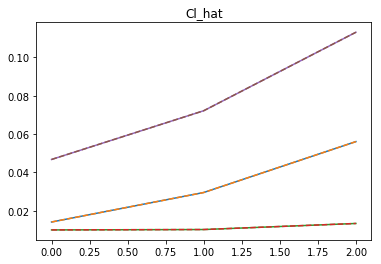

In [210]:
plt.plot(cl_hat[2][:,0,0])
plt.plot(jx_data[0][:,0,0], '--')

plt.plot(cl_hat[2][:,0,1])
plt.plot(jx_data[0][:,0,1], '--')

plt.plot(cl_hat[2][:,1,1])
plt.plot(jx_data[0][:,1,1], '--')
plt.title('Cl_hat')

In [168]:
cl_f = np.mean(cl_f_all, axis = 0)

Text(0.5, 1.0, 'Nl_mean 150x150')

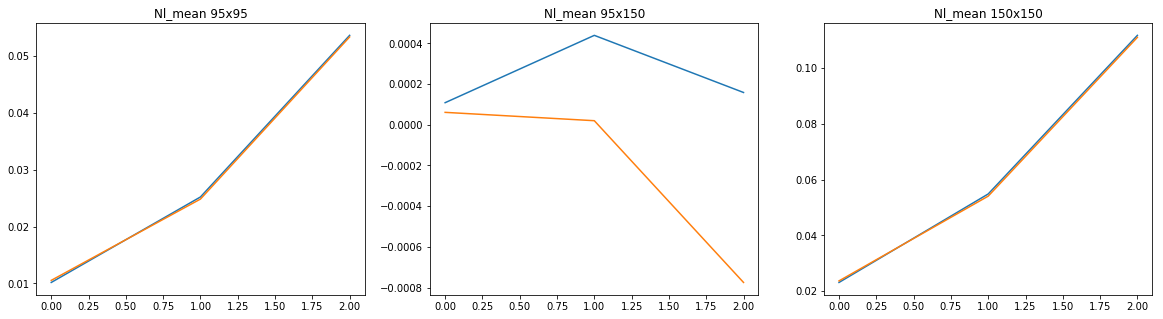

In [209]:
fig, axes = plt.subplots(1,3, figsize = (20, 5))

axes[0].plot(nl_mean[2][:,0,0])
axes[0].plot(jx_data[2][:,0,0])
axes[0].set_title('Nl_mean 95x95')

axes[1].plot(nl_mean[2][:,0,1])
axes[1].plot(jx_data[2][:,0,1])
axes[1].set_title('Nl_mean 95x150')

axes[2].plot(nl_mean[2][:,1,1])
axes[2].plot(jx_data[2][:,1,1])
axes[2].set_title('Nl_mean 150x150')

Text(0.5, 1.0, 'Cl_fiducial 150*150')

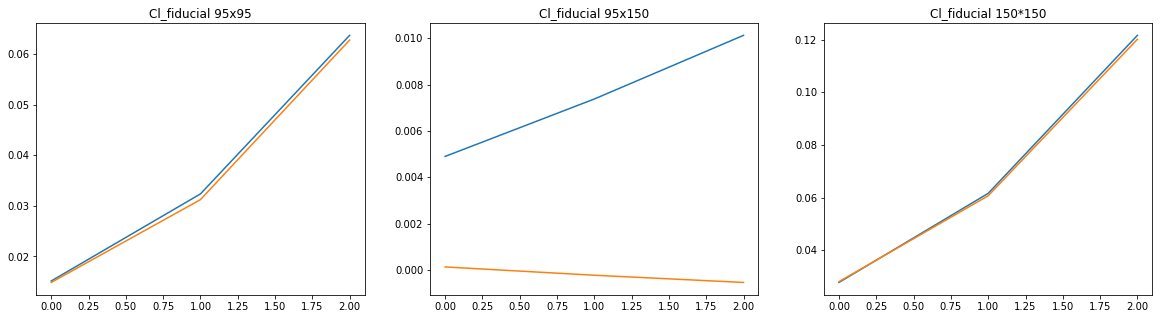

In [207]:
fig, axes = plt.subplots(1,3, figsize = (20, 5))

axes[0].plot(cl_f[2][:,0,0])
axes[0].plot(jx_data[1][:,0,0])
axes[0].set_title('Cl_fiducial 95x95')

axes[1].plot(cl_f[2][:,0,1])
axes[1].plot(jx_data[1][:,0,1])
axes[1].set_title('Cl_fiducial 95x150')

axes[2].plot(cl_f[2][:,1,1])
axes[2].plot(jx_data[1][:,1,1])
axes[2].set_title('Cl_fiducial 150*150')

In [124]:
LogL = logLike(2,lbin)
LogL.M(cl_f_all = cl_f_all, SamNum=20)

In [137]:
np.linalg.eigvals(LogL.Cov)

array([6.66505911e-05, 1.70093128e-05, 1.11029994e-05, 9.04266914e-06,
       3.70983306e-07, 1.21013467e-06, 2.19190407e-06, 5.36330302e-06,
       4.79905126e-06])

In [139]:
np.diag(jx_data[3])

array([4.06552402e-06, 4.21857438e-06, 8.80076562e-06, 7.35636391e-06,
       5.94621802e-06, 1.80538479e-05, 1.31946365e-05, 1.57816396e-05,
       3.12073606e-05])

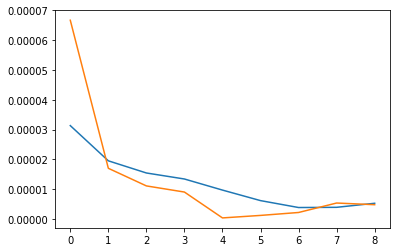

In [147]:
plt.plot(np.linalg.eigvals(jx_data[3]))
plt.plot(np.linalg.eigvals(LogL.Cov))

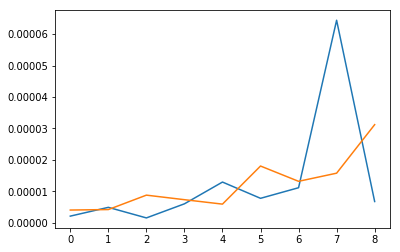

In [145]:
plt.plot(np.diag(LogL.Cov), label = 'yj')
plt.plot(np.diag(jx_data[3]), label = 'jx')

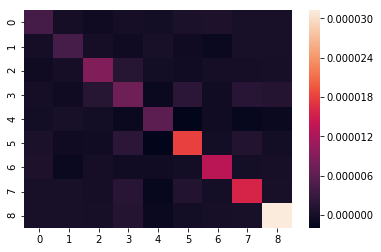

In [141]:
sns.heatmap(jx_data[3])

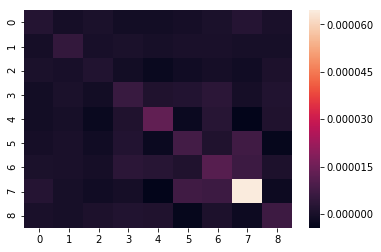

In [142]:
sns.heatmap(LogL.Cov)

# Dynesty

In [259]:
cl_f_all = np.load('/fnx/jianyao/DataChallenge/cl_f_all_nside_128.npy'); 
nl_all = np.load('/fnx/jianyao/DataChallenge/nl_all_nside_128.npy')
cl_hat = np.load('/fnx/jianyao/DataChallenge/cl_hat_ali_nside_128.npy')

In [224]:
cl_hat = [0,0,jx_data[0]];
cl_f = jx_data[1]
nl_mean = [0,0,jx_data[2]];
M = jx_data[3];

In [260]:
LogL = logLike(2,lbin) 

# LogL.Cov_inv = np.linalg.inv(M)

# LogL.cl_f = [0,0,cl_f]

LogL.M(cl_f_all = cl_f_all, SamNum=SamNum)

NameError: name 'LA' is not defined

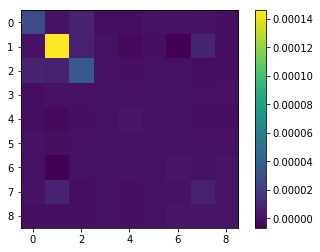

In [267]:
plt.imshow(LogL.Cov)
plt.colorbar()

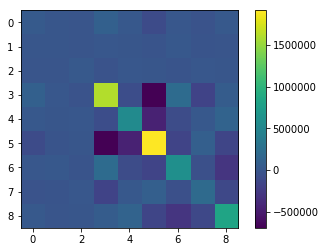

In [268]:
plt.imshow(LogL.Cov_inv)
plt.colorbar()

In [261]:
np.linalg.eigvals(LogL.Cov)

array([1.47213467e-04, 4.12262106e-05, 2.31925167e-05, 7.06594799e-06,
       3.14261307e-06, 2.41619767e-06, 3.86055813e-07, 1.01215461e-06,
       7.69047609e-07])

In [250]:
npara = 4; Nsim = 1; sbin = None; ebin = None

def prior(cube):
    
    r = cube[0]*0.2
    beta_s = cube[1]*4 - 4## from -4 to -2
#     beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8
    beta_d = cube[2]*2 + 1 
    epsilon = cube[3];
    
    return [r, beta_s, beta_d, epsilon]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim); Results = []
# LogL.Cov = LogL.Cov*10.0;

for n in range(0, Nsim):
      
    def log_likelihood(cube, subtract = False):
        
        r_i = cube[0];
        beta_s = cube[1];
        beta_d = cube[2];
        epsilon = cube[3];

        cl_th_test = combine_ps(r_i)  ## combine the tensor bb and lensing bb
        
        fl_hat = sync_ps_v0(A_s_tem, beta_s, lbin) + dust_ps_v0(A_d_tem, beta_d, lbin) + corre_fore_simple(epsilon, A_d_tem, A_s_tem, beta_s, beta_d, lbin)
        
        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean[2] + fl_hat
        
        logL =LogL.run(cl_hat=(cl_hat[2]) , cl_th = C_l, likelihood='HL'); 
#         print(logL)
        return np.real(logL)
    
    with Pool(cpu_count()-1) as executor:
        
        sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
        sampler.run_nested()
        results = sampler.results
    Results.append(results)
    
    if n == 0 : 
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
    else: 
        _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
        samples = np.r_[samples, _samples];
        weights = np.r_[weights, _weights];

4386it [00:09, 458.60it/s, +400 | bound: 18 | nc: 1 | ncall: 24120 | eff(%): 19.842 | loglstar:   -inf < -28.060 <    inf | logz: -38.092 +/-  0.219 | dlogz:  0.001 >  0.409]


## Figures

### with lensing

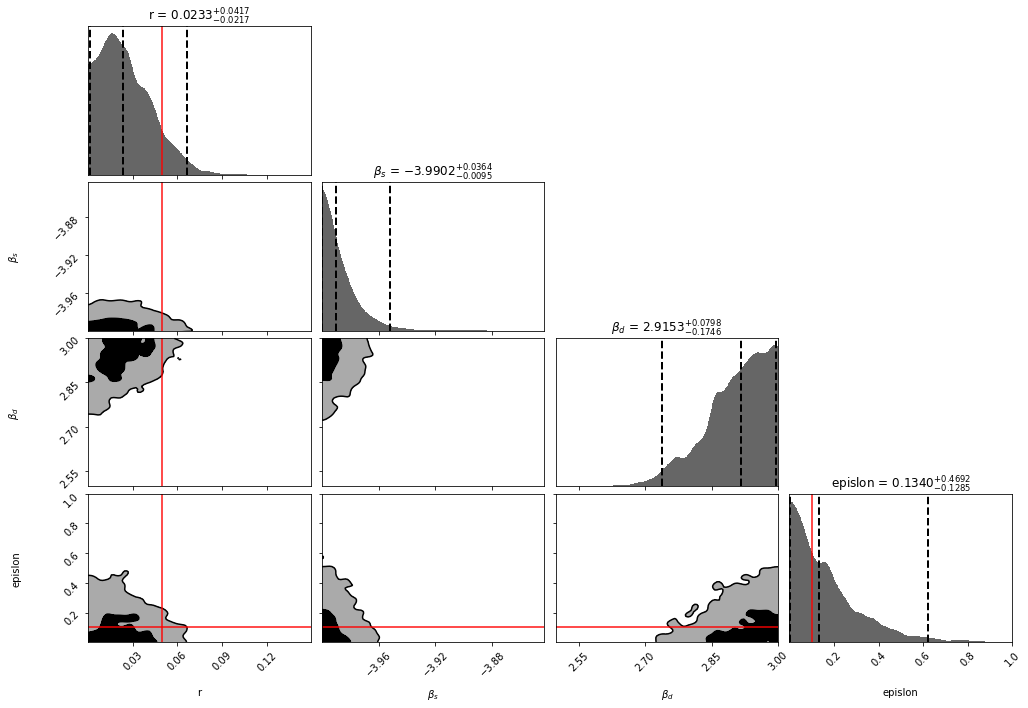

In [46]:
# HL-with lensing

truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

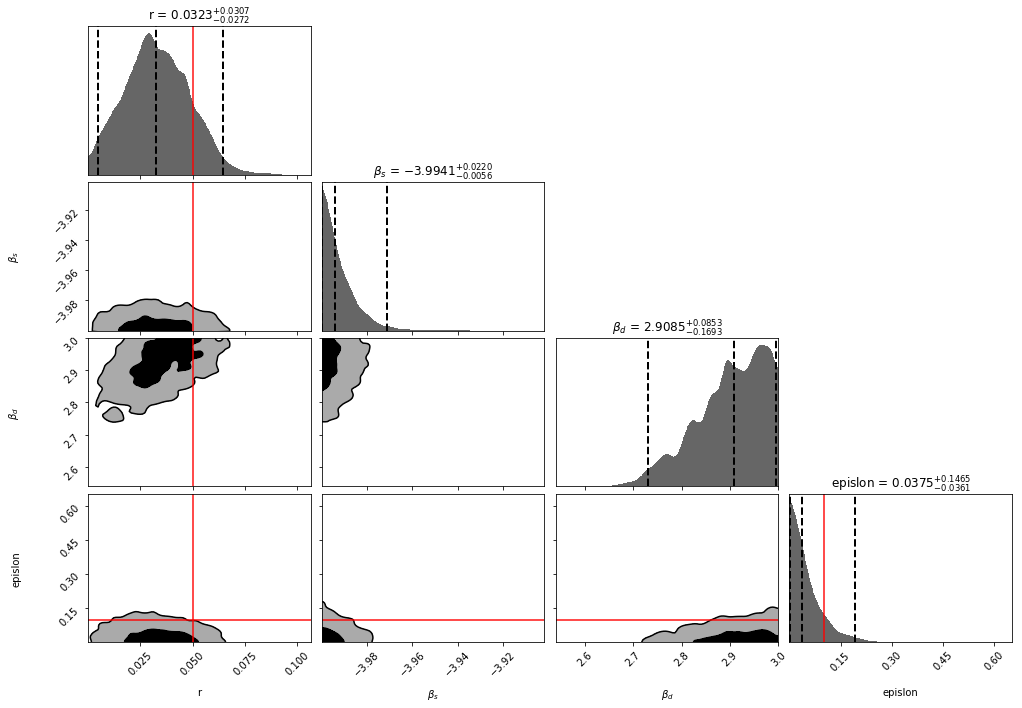

In [48]:
## Gaussian likelihood - with lensing 

truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

### without lensing

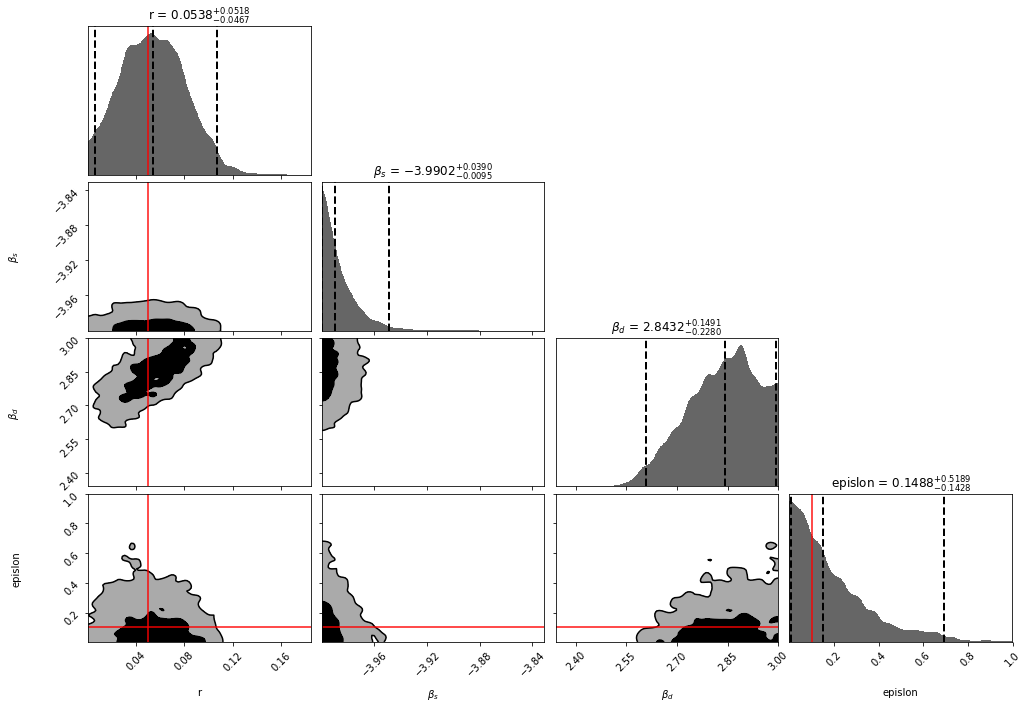

In [74]:
## HL - without lensing 

truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

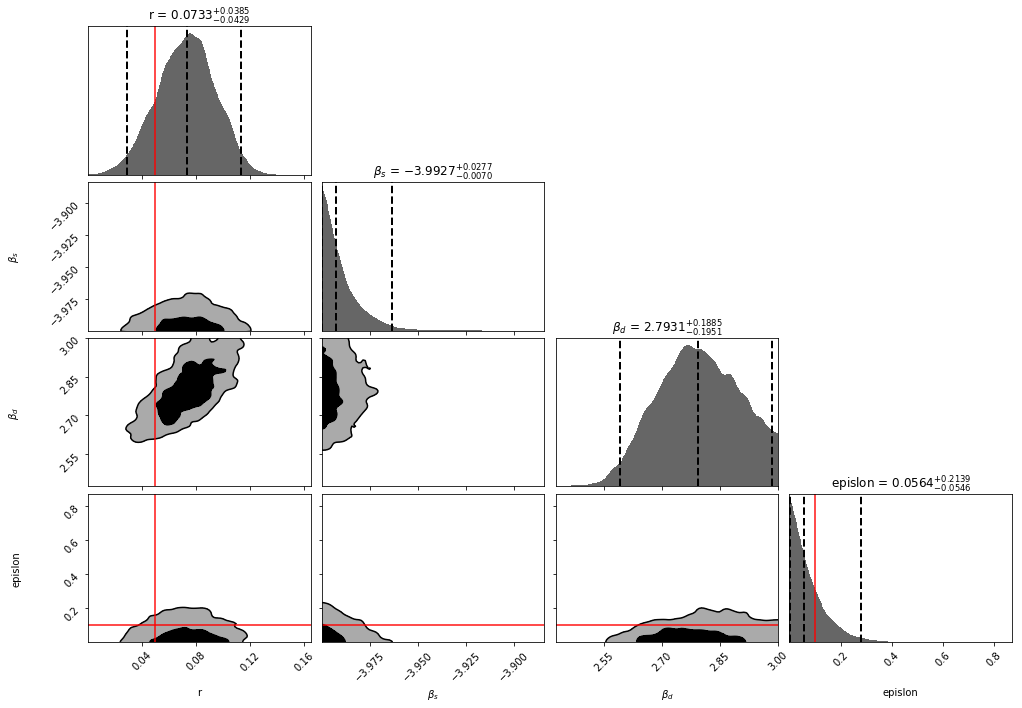

In [76]:
## Gaussian likelihood - without lensing 

truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

### My data

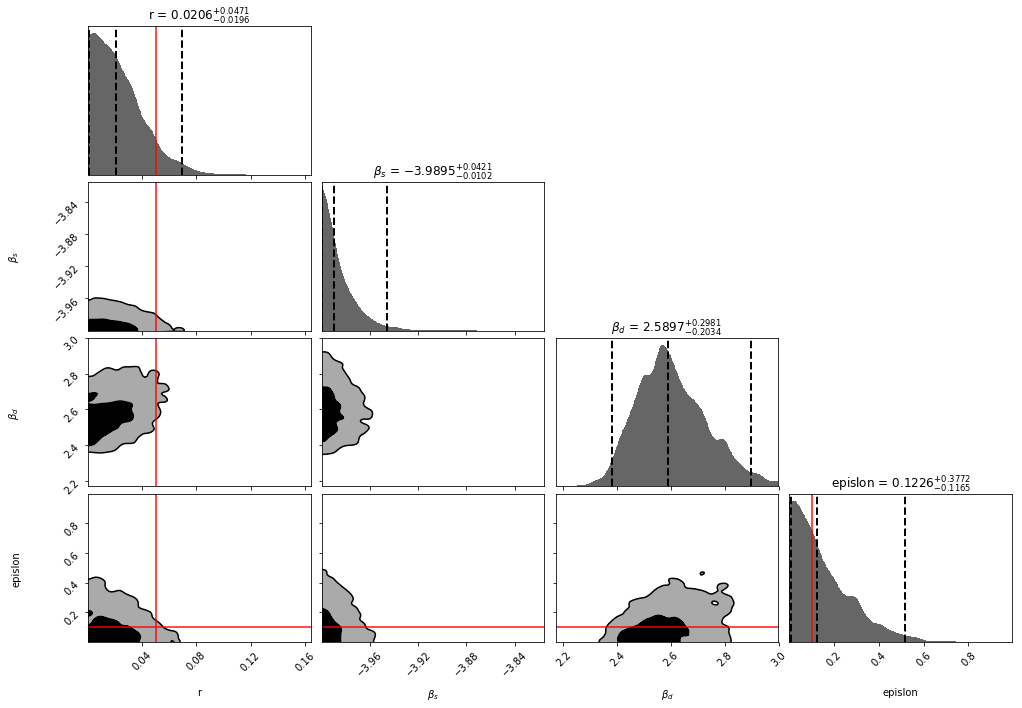

In [251]:
##likelihood - without lensing 

truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

# Minuit

In [87]:
nl_mean.shape

(3, 12, 2, 2)

In [88]:
cl_hat.shape

(3, 12, 2, 2)

In [89]:
A_d_tem.shape

(12,)

In [90]:
combine_ps(0.05).shape

(12, 2, 2)

In [91]:
method = 'Gauss'; sbin = 1; ebin = 10
def Min_log_likelihood(r_i, beta_s, beta_d, epsilon):
   
    fl_hat = sync_ps_v0(A_s_tem, beta_s, lbin) + dust_ps_v0(A_d_tem, beta_d, lbin) + corre_fore_simple(epsilon, A_d_tem, A_s_tem, beta_s, beta_d, lbin)

    C_l = combine_ps(r_i) + nl_mean[2] + fl_hat;
   
    if method == 'HL':
        logL_nu = utils.testL(cl_hat = cl_hat[2], cl_f = LogL.cl_f[2], cl_th = C_l, Nf = Nf, M_inv = LogL.Cov_inv)
            
    elif method == 'Gauss':
        logL_nu = utils.simple_likelihood(cl_hat[2], C_l, Nf = Nf, M_inv = LogL.Cov_inv,sbin = 1, ebin = 10)
            
    return -2*logL_nu

In [92]:
m = Minuit(Min_log_likelihood, r_i = 0.05, beta_s = -3, beta_d = 2.7, epsilon = 0.1,limit_r_i = (0,0.2), limit_beta_s = (-4,4), limit_beta_d = (1,3), limit_epsilon = (0,1), errordef = Minuit.LIKELIHOOD)

In [93]:
## HL
m.migrad()

## 0.0538; 0.025

------------------------------------------------------------------
| FCN = 1.717e+20               |     Ncalls=224 (225 total)     |
| EDM = 8.31e+04 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
---------------------------------------------------------------------------------------------
|   | Name    |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------
| 0 | r_i     |   2e-1    |   0e-1    |            |            |    0    |   0.2   |       |
| 1 | beta_s  |    -4     |     0     |            |            |   -4    |    4    |       |
| 2 | beta_d  |     1     |     0     |            |            |    1    |    3    |       |
| 3 | epsilon |     1     |     0     |            |            |    0    |    1    |       |
---------------------------------------------------------------------------------------------

In [102]:
## Gaussian

m.migrad()

## 0.0733; 0.01925

------------------------------------------------------------------
| FCN = 87.66                   |     Ncalls=223 (223 total)     |
| EDM = 5.56e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
---------------------------------------------------------------------------------------------
|   | Name    |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------
| 0 | r_i     |   0.075   |   0.015   |            |            |    0    |   0.2   |       |
| 1 | beta_s  |  -4.0000  |  0.0027   |            |            |   -4    |    4    |       |
| 2 | beta_d  |   2.75    |   0.08    |            |            |    1    |    3    |       |
| 3 | epsilon |   0.00    |   0.02    |            |            |    0    |    1    |       |
---------------------------------------------------------------------------------------------

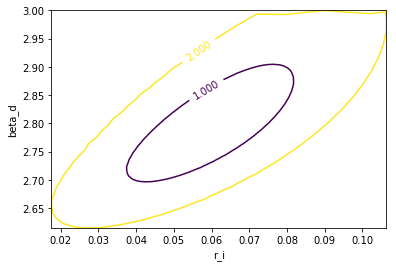

In [117]:
m.draw_mncontour('r_i','beta_d', nsigma=2);  #

In [121]:
m.matrix()

---------------------------------------------
|         |     r_i  beta_s  beta_d epsilon |
---------------------------------------------
|     r_i |   0.000  -0.000   0.002  -0.000 |
|  beta_s |  -0.000   0.000  -0.000   0.000 |
|  beta_d |   0.002  -0.000   0.011   0.000 |
| epsilon |  -0.000   0.000   0.000   0.000 |
---------------------------------------------